In [ ]:
# ======================================
# 1) IMPORTS
# ======================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/My Drive/Dataset/Dataset"
test_dir    = "/content/drive/MyDrive/Test/Test"

In [ ]:
# ======================================
# 3) CLASS NAME MAPPING
# ======================================
label_names = {
    0: "Covid-19",
    1: "Normal",
    2: "Viral Pneumonia",
    3: "Bacterial Pneumonia"
}

In [ ]:
# ======================================
# 3) DATA LOADERS
# ======================================
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1/255)


In [ ]:
# Training split
train_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=25,
    class_mode="categorical",
    subset="training"
)


# Validation split
val_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=25,
    class_mode="categorical",
    subset="validation"
)

# Test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=25,
    class_mode="categorical",
    shuffle=False
)

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


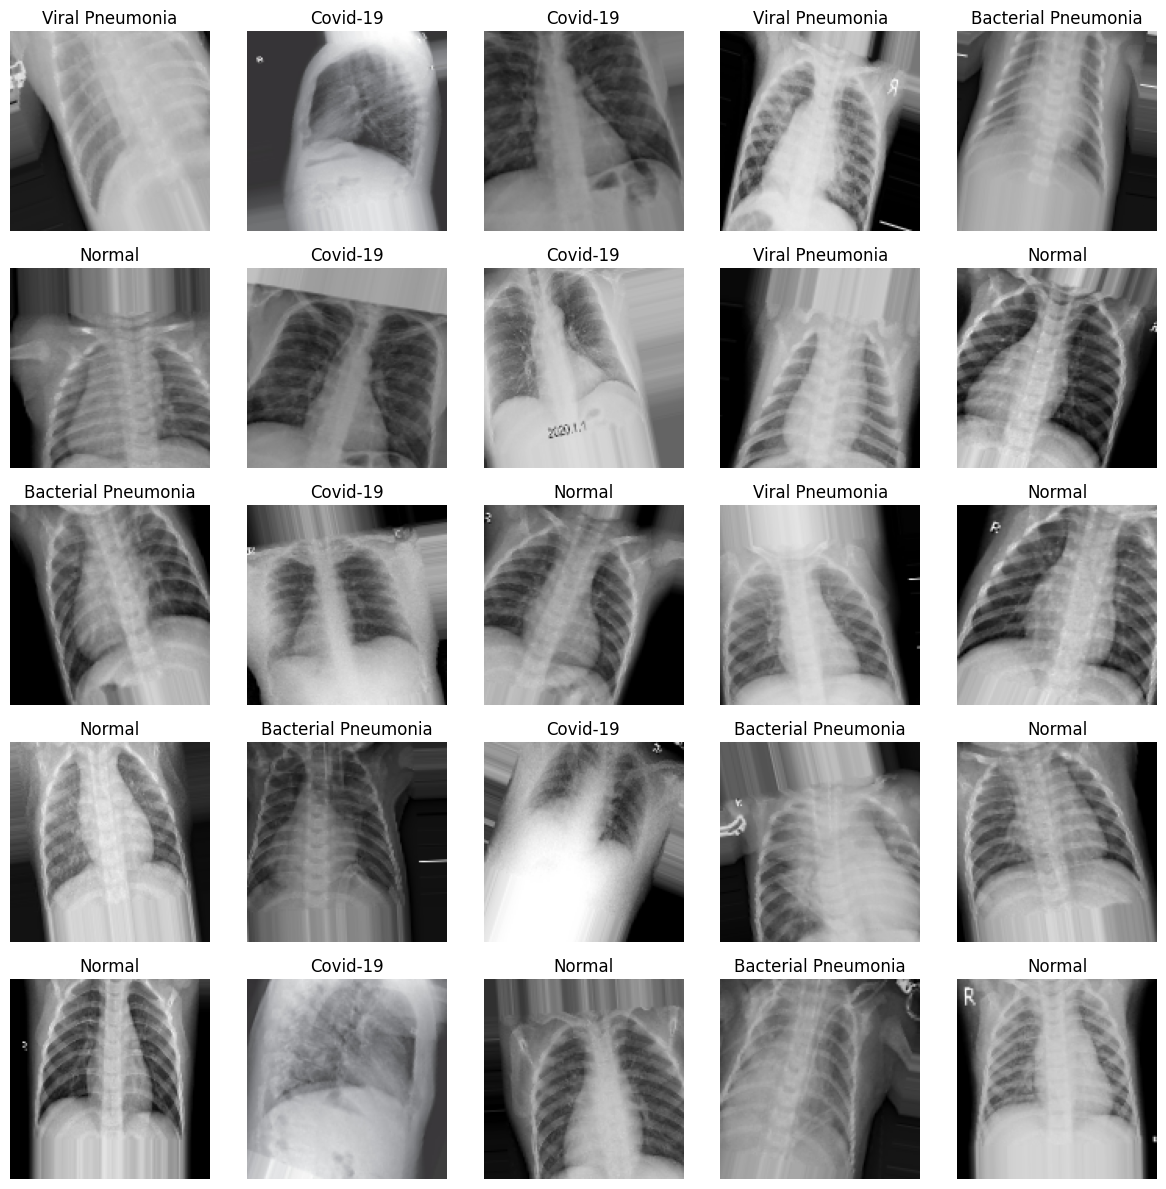

In [ ]:
# ======================================
# 5) DATASET IMAGE PREVIEW
# ======================================
images, labels = next(train_data)

L, W = 5, 5
fig, axes = plt.subplots(L, W, figsize=(12,12))

for i in range(L * W):
    ax = axes[i // W, i % W]
    ax.imshow(images[i])
    cls = np.argmax(labels[i])
    ax.set_title(label_names[cls])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ======================================
# 4) BUILD MODEL (MobileNetV2)
# ======================================
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# ======================================
# 5) COMPILE
# ======================================
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ======================================
# 6) TRAIN MODEL
# ======================================
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 322s 18s/step - accuracy: 0.3798 - loss: 1.8538 - val_accuracy: 0.5673 - val_loss: 1.1082
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step - accuracy: 0.6775 - loss: 1.0312 - val_accuracy: 0.6635 - val_loss: 1.1133
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.6475 - loss: 1.0206 - val_accuracy: 0.6731 - val_loss: 1.0274
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.7381 - loss: 0.8773 - val_accuracy: 0.6442 - val_loss: 1.0508
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - accuracy: 0.7997 - loss: 0.7265 - val_accuracy: 0.6250 - val_loss: 1.0525
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.8049 - loss: 0.6942 - val_accuracy: 0.5962 - val_loss: 1.1166


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_names = ["Covid-19", "Normal", "Viral Pneumonia", "Bacterial Pneumonia"]

def predict_disease(image_path):
    img = image.load_img(image_path, target_size=(128,128))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)

    print("\n Probabilities for each class:")
    for label, prob in zip(class_names, prediction[0]):
        print(f"{label} : {prob:.3f}")

    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = prediction[0][predicted_index]

    print("\n Predicted Disease:", predicted_class)
    print(" Confidence:", confidence)

    return predicted_class, confidence
test_image_path = "/content/drive/My Drive/Dataset/Dataset/1/NORMAL2-IM-0373-0001.jpeg"  # <-- change to your test image
predict_disease(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

 Probabilities for each class:
Covid-19 : 0.002
Normal : 0.471
Viral Pneumonia : 0.147
Bacterial Pneumonia : 0.380

 Predicted Disease: Normal
 Confidence: 0.47139946


('Normal', np.float32(0.47139946))

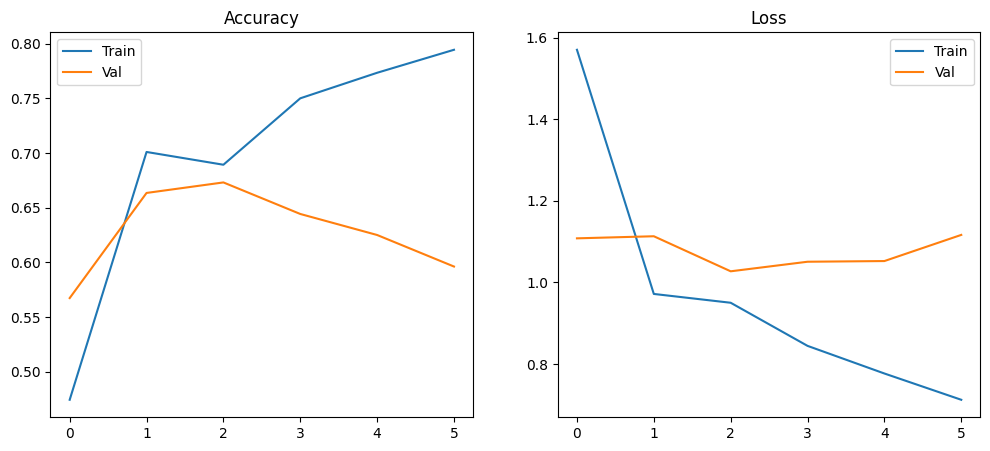

In [ ]:
# ======================================
# 7) PLOT LEARNING CURVES
# ======================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train","Val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train","Val"])

plt.show()

In [ ]:
# ======================================
# 8) TEST EVALUATION
# ======================================
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 10s/step - accuracy: 0.6900 - loss: 1.0791
Test Accuracy: 0.675000011920929


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step

Classification Report:

                     precision    recall  f1-score   support

           Covid-19       1.00      0.70      0.82        10
             Normal       0.60      0.90      0.72        10
    Viral Pneumonia       0.67      0.20      0.31        10
Bacterial Pneumonia       0.60      0.90      0.72        10

           accuracy                           0.68        40
          macro avg       0.72      0.68      0.64        40
       weighted avg       0.72      0.68      0.64        40



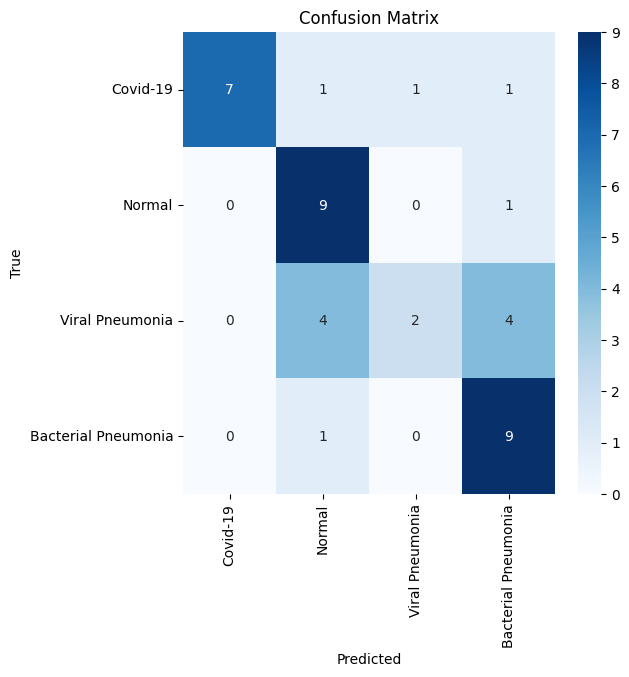

In [ ]:
# ======================================
# 9) CONFUSION MATRIX + CLASSIFICATION REPORT
# ======================================

class_names = ["Covid-19", "Normal", "Viral Pneumonia", "Bacterial Pneumonia"]

pred_probs = model.predict(test_data)
pred = np.argmax(pred_probs, axis=1)
true = test_data.classes

print("\nClassification Report:\n")
print(classification_report(true, pred, target_names=class_names))

cm = confusion_matrix(true, pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
